# Generative Models
***

**Autumn 2023, MSc course**


## Assignment 1

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Alexander Panfilov*

***


The assignment is split into two parts: at first, you will implement classical GAN for the MNIST dataset, and after, you will enhance your results with DCGAN and the CIFAR dataset.

Good luck!

## 1. GAN
*Source: <a href="https://arxiv.org/pdf/1406.2661.pdf" target="_blank">Goodfellow, Ian J., et al. "Generative Adversarial Networks." arXiv preprint arXiv:1406.2661 (2014)</a>.*

In 2014, Ian Goodfellow and his colleagues at the University of Montreal published a stunning paper introducing the world to GANs, or generative adversarial networks. The models play two distinct (literally, adversarial) roles. Given some real data set $\mathcal{X}$, $G$ is the generator, trying to create fake data that looks just like the genuine data, while $D$ is the discriminator, getting data from either the real set or $G$ and labeling the difference.

Goodfellow’s metaphor (and a fine one it is) was that $G$ was like a team of forgers trying to match real paintings with their output, while $D$ was the team of detectives trying to tell the difference. (Except in this case, the forgers $G$ never get to see the original data — only the judgments of $D$. They’re like blind forgers.)

<img src="https://production-media.paperswithcode.com/methods/gan.jpeg" style="display=block; margin:auto"/>
<p style="text-align: center">
    <b>Picture taken from the <a href="https://paperswithcode.com/method/gan" target="_blank">paperswithcode</a> website. There you can find a whole bunch of papers on GANs with implementation.</b>
</p>

In this part, we are going to implement classical GAN. You can find a rough plan on how to do it below; however, it is not mandatory to stick with it precisely but one might expect some questions related to the listed steps. Feel free to adapt provided code!

- Define the parameters
- Load the data (with transforms and normalization)
- Denormalize for visual inspection of samples
- Define the Discriminator network, the Generator network
- Study the activation function: Leaky ReLU
- Explain the output activation function: Tanh, Sigmoid
- Look at some sample outputs
- Define losses, optimizers and helper functions for training
     - For Discriminator
     - For Generator
- Train the model
- Save intermediate generated images to file
- Look at some outputs
- Save the models

### Imports

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.utils import save_image

%matplotlib inline
plt.style.use("ggplot")

### Define parameters & data loading

In [2]:
hidden_size = 256
batch_size = 100
LR = 0.0002
num_epochs = 300
sample_dir = "./images"
latent_size = 64  # input random input vector latent
image_size = 784  # 28*28 flatten
device = "cuda" if torch.cuda.is_available() else "cpu"

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
## Define the dataset
mnist_dataset = MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]),
)

100%|██████████| 9912422/9912422 [00:00<00:00, 140839607.33it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 110323947.02it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 68246458.81it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21096931.08it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Label:  5


(array([55.,  4.,  3.,  0.,  3.,  2.,  1.,  0.,  1.,  3.,  1.,  3.,  2.,
         1., 21.]),
 array([-1.        , -0.86771244, -0.73542482, -0.60313725, -0.47084966,
        -0.3385621 , -0.20627451, -0.07398693,  0.05830066,  0.19058824,
         0.32287583,  0.45516339,  0.58745098,  0.71973854,  0.85202616,
         0.98431373]),
 <BarContainer object of 15 artists>)

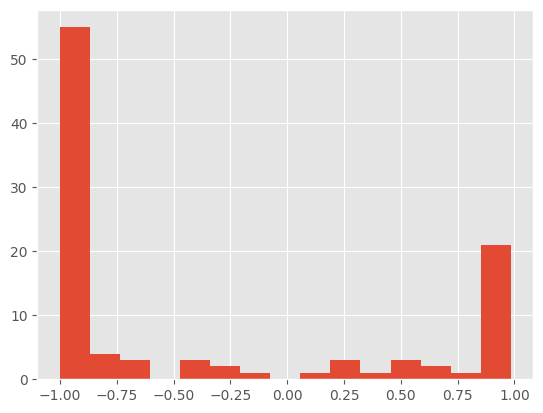

In [ ]:
img, label = mnist_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

In [ ]:
# denormalization image from range (-1)-1 to range 0-1 to display it
def denorm(x):
    return (x -(-1))/2

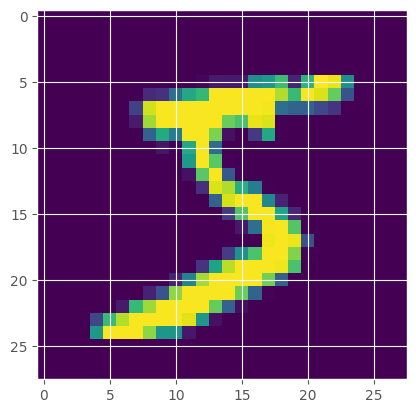

In [ ]:
# show image sample with matplotlib
img = denorm(img)     # Denormalize
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [ ]:
# define the dataloader
data_loader = torch.utils.data.DataLoader(dataset=mnist_dataset, batch_size=batch_size, shuffle=True)

### GAN implementation

GAN consists of two deep networks, a generator ($G$) and a discriminator ($D$). The generator creates images before learning it. Since the discriminator is a binary classification model, we can use the binary cross-entropy loss function to quantify how well it can distinguish between real and generated images.

In [10]:
class Generator(nn.Module):
    def __init__(self, latent_size, image_size, hidden_size):
        super(Generator, self).__init__()
        ## set a linear layer with input size is latent_size and output size is hidden_size
        self.fc1 = nn.Linear(latent_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is hidden_size
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is image_size
        self.fc3 = nn.Linear(hidden_size, image_size)

    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> tanh
        x = torch.tanh(self.fc3(F.relu(self.fc2(F.relu(self.fc1(x))))))
        return x


class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size):
        super(Discriminator, self).__init__()
        ## set a linear layer with input size is image_size and output size is hidden_size
        self.fc1 = nn.Linear(image_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is hidden_size
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is 1
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> sigmoid
        x = torch.sigmoid(self.fc3(F.relu(self.fc2(F.relu(self.fc1(x))))))
        return x

### Create the Generator and Discriminator

In [11]:
# create new Generator model

G = Generator(latent_size, image_size, hidden_size)

# create new Discriminator model

D = Discriminator(image_size, hidden_size)

In [ ]:
img.shape

torch.Size([1, 28, 28])

In [ ]:
# show the output of model
y = G(torch.randn(2, latent_size))

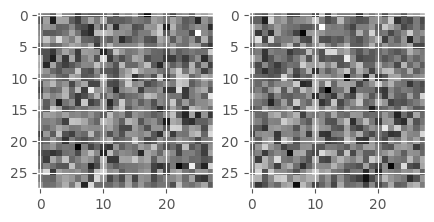

In [ ]:
plt.figure(figsize=(5,5))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(y[i].cpu().detach().view(28, 28), cmap='gray')
plt.show()

In [ ]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()
## Define the optimizer for generator and discrimator
G_optimizer = torch.optim.Adam(G.parameters(), lr=LR)
D_optimizer = torch.optim.Adam(D.parameters(), lr=LR)

Discriminator Training

In [ ]:
def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    G_optimizer.zero_grad()
    D_optimizer.zero_grad()

def train_discriminator(D_model, G_model, images):

    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)


    outputs = D_model(images)
    # Loss for real images
    real_score = criterion(outputs, real_labels)

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G_model(z)
    outputs = D_model(fake_images)

    fake_score = criterion(outputs, fake_labels)

    # Sum losses
    d_loss = real_score + fake_score
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    D_optimizer.step()
    return d_loss, real_score, fake_score

Generator Training

In [ ]:
def train_generator(G_model):
    # Generate fake images and calculate loss
    # z = torch.randn(batch_size, latent_size).to(device)
    z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(device)
    fake_images = G_model(z)
    labels = torch.ones(batch_size, 1).to(device)
    # calculate the generator loss
    g_loss = criterion(D(fake_images), labels)
    # Reset gradients
    reset_grad()
    # Backprop and optimize
    g_loss.backward()
    G_optimizer.step()
    return g_loss, fake_images

### Start the training proccess

In [ ]:
# function to save the sample output of generator
def save_fake_images_mnist(G_model, index):
    # sample_vectors = torch.randn(batch_size, latent_size).to(device)
    sample_vectors = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(
        device
    )
    fake_images = G_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [ ]:
%%time
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(D, G, images)
        # Train the generator
        g_loss, fake_images = train_generator(G)
        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images_mnist(G, epoch + 1)

Epoch [0/300], Step [200/600], d_loss: 0.3088, g_loss: 3.2026, D(x): 0.08, D(G(z)): 0.23
Epoch [0/300], Step [400/600], d_loss: 0.4018, g_loss: 2.2772, D(x): 0.18, D(G(z)): 0.22
Epoch [0/300], Step [600/600], d_loss: 0.2780, g_loss: 4.1207, D(x): 0.12, D(G(z)): 0.16
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.5277, g_loss: 2.4739, D(x): 0.21, D(G(z)): 0.32
Epoch [1/300], Step [400/600], d_loss: 2.2440, g_loss: 1.5460, D(x): 1.51, D(G(z)): 0.74
Epoch [1/300], Step [600/600], d_loss: 0.1714, g_loss: 3.5786, D(x): 0.06, D(G(z)): 0.11
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.3606, g_loss: 3.5055, D(x): 0.24, D(G(z)): 0.12
Epoch [2/300], Step [400/600], d_loss: 0.1439, g_loss: 2.9736, D(x): 0.04, D(G(z)): 0.10
Epoch [2/300], Step [600/600], d_loss: 0.8964, g_loss: 2.0705, D(x): 0.69, D(G(z)): 0.21
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.7290, g_loss: 2.0036, D(x): 0.40, D(G(z)): 0.33
Epoch [3/300], Step [400/6

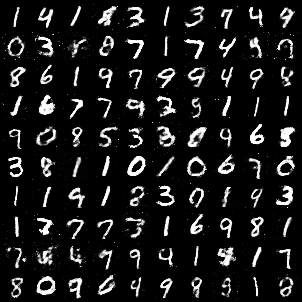

In [ ]:
# show output after epochs training
from IPython.display import Image
Image(os.path.join(sample_dir, "fake_images-0225.png"))

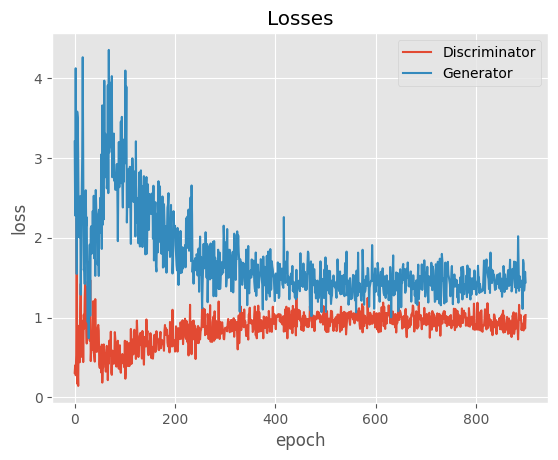

In [ ]:
# show the discrimator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

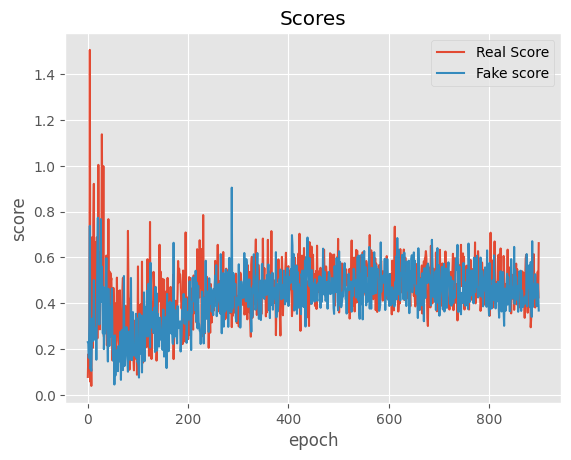

In [ ]:
# plot the accuracy of discrimator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");

## 2. DCGAN

*Source: <a href="https://arxiv.org/pdf/1511.06434v2.pdf" target="_blank">Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015)</a>.*

The goal of this part is to enhance your results achieved in the part one with DCGAN. Feel free to reuse your code, improve architecture or training scheme, etc.

In [38]:
class CFG:
    batch_size = 128
    num_epochs = 150
    workers = 2
    seed = 2021
    image_size = 64
    download = True
    dataroot = "data"
    nc = 3  ## number of channels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.0002
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sample_dir = "./images/"


if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

Files already downloaded and verified


Label:  6


(array([ 3.,  6., 52., 36.,  6.,  4., 12., 40., 40.,  7.,  2.,  6., 22.,
        32., 32.]),
 array([-0.87450981, -0.81124181, -0.74797386, -0.68470585, -0.62143791,
        -0.5581699 , -0.49490196, -0.43163398, -0.36836597, -0.305098  ,
        -0.24183004, -0.17856206, -0.11529408, -0.0520261 ,  0.01124188,
         0.07450986]),
 <BarContainer object of 15 artists>)

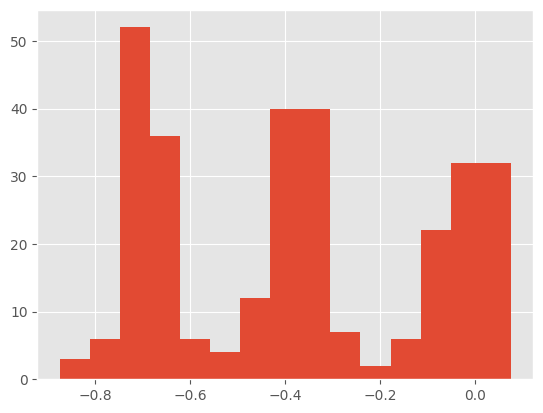

In [4]:
img, label = cifar_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

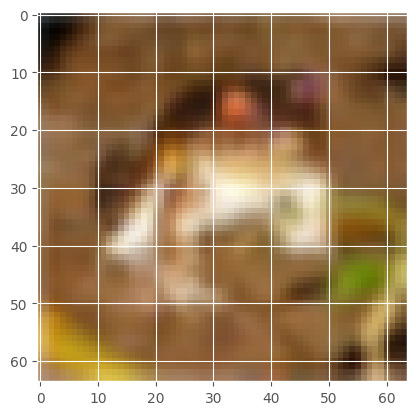

In [5]:
# unnormalization image from range (-1)-1 to range 0-1 to display it
def denorm(img):
    # write your code
    return (img + 1) / 2

# show  image sample with matplotlib
def imshow(img):
    img = denorm(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(img)

In [39]:
# create the dataloader
data_loader = torch.utils.data.DataLoader(dataset=cifar_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=True,
                                          num_workers=CFG.workers)

### DCGAN implementation

In [15]:
class DCGenerator(nn.Module):
    def __init__(self, nc, nz, ngf):
        # ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu
        # ConvTranspose2d - BatchNorm - Relu - ConvTranspose2d - Tanh
        super(DCGenerator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.main(x)
        return x


class DCDiscriminator(nn.Module):
    def __init__(self, nc, ndf):
        # conv2d - leaky - conv2d - batchnorm - leaky - conv2d - batchnorm - leaky - conv - batchnorm - leaky - conv2d
        super(DCDiscriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        return x

In [16]:
# create new Generator model

DCG = DCGenerator(CFG.nc, CFG.nz, CFG.ngf)

# create new Discriminator model

DCD = DCDiscriminator(CFG.nc, CFG.ndf)

In [18]:
# show the output of model
y = DCG(torch.randn(2, CFG.nz, 1, 1))

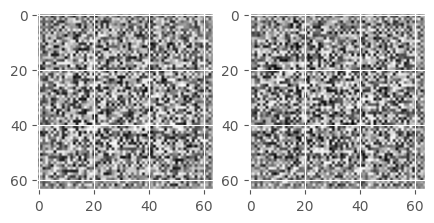

In [19]:
plt.figure(figsize=(5, 5))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(y[i][0].cpu().detach().numpy(), cmap='gray')
plt.show()

In [27]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()
## Define the optimizer for generator and discrimator
D_optimizer = torch.optim.Adam(DCD.parameters(), lr=CFG.lr, betas=(0.5, 0.999))
G_optimizer = torch.optim.Adam(DCG.parameters(), lr=CFG.lr, betas=(0.5, 0.999))

In [ ]:
# feel free to reuse your training functions

### Start the training proccess

In [21]:
def save_fake_images_cifar(DCG_model, index):
    sample_vectors = torch.randn(CFG.batch_size, CFG.nz, 1, 1).to(CFG.device)
    fake_images = DCG_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(
        denorm(fake_images), os.path.join(CFG.sample_dir, fake_fname), nrow=10
    )

In [25]:
def train_discriminator(D_model, G_model, images):
    # Train the discriminator
    D_model.zero_grad()

    images = images.view(-1, 3, 64, 64)

    real_output = D_model(images)
    real_loss = criterion(real_output, torch.ones(images.size(0), 1, 1, 1, device=device))
    real_score = real_output

    z = torch.randn(images.size(0), CFG.nz, 1, 1, device=device)
    fake_images = G_model(z)
    fake_output = D_model(fake_images.detach())
    fake_loss = criterion(fake_output, torch.zeros(images.size(0), 1, 1, 1, device=device))
    fake_score = fake_output

    d_loss = real_loss + fake_loss
    d_loss.backward()
    D_optimizer.step()

    return d_loss, real_score, fake_score

def train_generator(G_model):
    # Train the generator
    G_model.zero_grad()
    z = torch.randn(batch_size, CFG.nz, 1, 1, device=device)
    fake_images = G_model(z)
    fake_output = DCD(fake_images)
    g_loss = criterion(fake_output, torch.ones(batch_size, 1, 1, 1, device=device))
    g_loss.backward()
    G_optimizer.step()

    return g_loss, fake_images


In [40]:
%%time
device = CFG.device
num_epochs = CFG.num_epochs
batch_size = CFG.batch_size

total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
DCG.to(device)
DCD.to(device)

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        images = images.view(-1, 3, 64, 64)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(D_model=DCD, G_model=DCG, images=images)

        # Train the generator
        g_loss, fake_images = train_generator(G_model=DCG)

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images_cifar(DCG, epoch + 1)

Epoch [0/150], Step [200/391], d_loss: 0.1978, g_loss: 3.6001, D(x): 0.89, D(G(z)): 0.07
Saving fake_images-0001.png
Epoch [1/150], Step [200/391], d_loss: 1.2595, g_loss: 5.3479, D(x): 0.99, D(G(z)): 0.66
Saving fake_images-0002.png
Epoch [2/150], Step [200/391], d_loss: 1.8650, g_loss: 8.2245, D(x): 1.00, D(G(z)): 0.75
Saving fake_images-0003.png
Epoch [3/150], Step [200/391], d_loss: 0.3502, g_loss: 2.4005, D(x): 0.79, D(G(z)): 0.08
Saving fake_images-0004.png
Epoch [4/150], Step [200/391], d_loss: 0.2677, g_loss: 3.4891, D(x): 0.95, D(G(z)): 0.18
Saving fake_images-0005.png
Epoch [5/150], Step [200/391], d_loss: 0.0907, g_loss: 4.2654, D(x): 0.94, D(G(z)): 0.03
Saving fake_images-0006.png
Epoch [6/150], Step [200/391], d_loss: 0.1857, g_loss: 3.7317, D(x): 0.91, D(G(z)): 0.09
Saving fake_images-0007.png
Epoch [7/150], Step [200/391], d_loss: 0.0964, g_loss: 5.2055, D(x): 0.94, D(G(z)): 0.03
Saving fake_images-0008.png
Epoch [8/150], Step [200/391], d_loss: 1.0750, g_loss: 4.2247, D

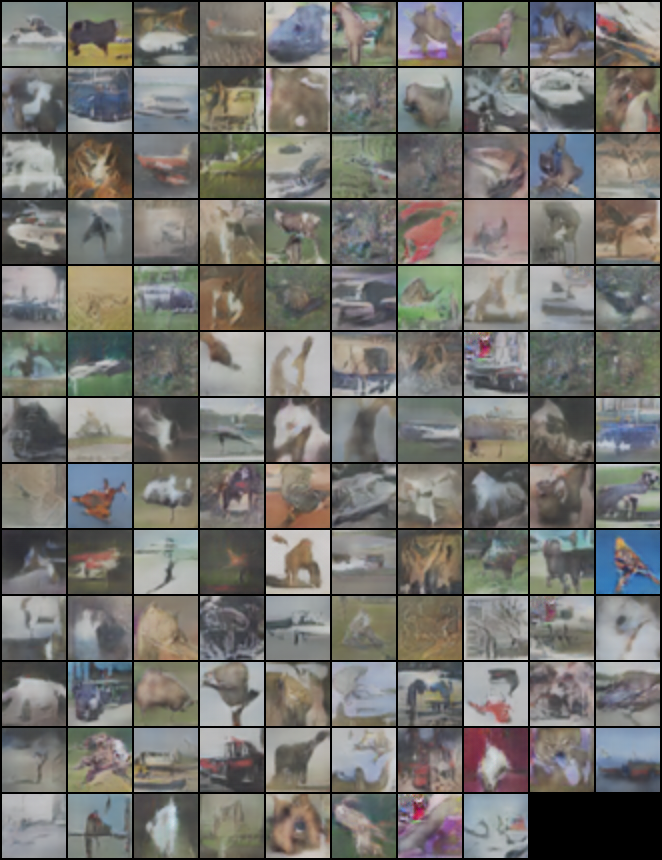

In [44]:
# show output after epochs training
from IPython.display import Image
Image(os.path.join(sample_dir, "fake_images-0102.png"))

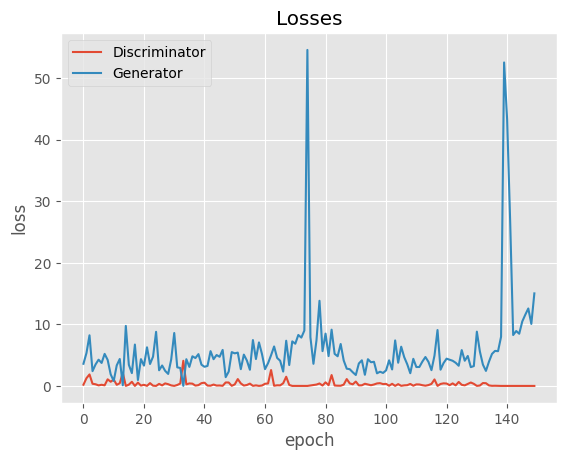

In [45]:
# show the discrimator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

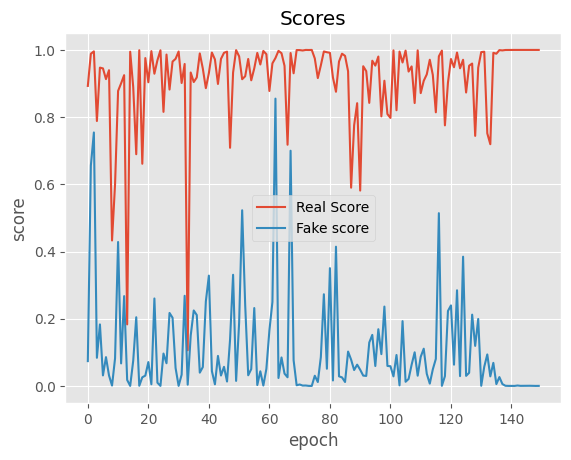

In [46]:
# plot the accuracy of discrimator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");